# Introduksjon

Denne notebooken utforsker simulering av smittespredning ved hjelp av SEIR- og SEIRV-modeller, inkludert Monte Carlo-simuleringer for å analysere usikkerhet i epidemiologiske parametere. Vi benytter ulike sykdomsparametre, vaksinasjonsdekning og vaksineeffektivitet for å undersøke hvordan disse påvirker utbruddets forløp. Visualiseringer og statistiske analyser gir innsikt i sammenhenger mellom modellparametere og utfall, samt effekten av vaksinasjon på smittespredning.

Først må vi lese inn noen Python biblioteker. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.integrate import odeint
import ipywidgets as widgets
from IPython.display import display




I den neste cellen definerer vi parametre for noen sykdommer. Disse har jeg bedt Copilot om å hente for meg, så de er ikke nødvendigvis riktige.

In [2]:
# Definer sykdomsparametere
disease_params = {
    "COVID-19": {
        "R0": {"mean": 3.0, "CI": (2.0, 3.8)},
        "incubation": {"mean": 5.2, "CI": (4.8, 6.2), "unit": "days"},
        "infectious_period": {"mean": 10.0, "CI": (7.0, 14.0), "unit": "days"},
        "serial_interval": {"mean": 6.0, "CI": (3.5, 8.5), "unit": "days"}
    },
    "Influensa": {
        "R0": {"mean": 1.5, "CI": (1.2, 2.0)},
        "incubation": {"mean": 1.8, "CI": (1.0, 4.0), "unit": "days"},
        "infectious_period": {"mean": 5.0, "CI": (3.0, 7.0), "unit": "days"},
        "serial_interval": {"mean": 2.2, "CI": (1.5, 3.0), "unit": "days"}
    },
    "Meslinger": {
        "R0": {"mean": 15.0, "CI": (11.0, 20.0)},
        "incubation": {"mean": 11.5, "CI": (7.0, 18.0), "unit": "days"},
        "infectious_period": {"mean": 8.0, "CI": (7.0, 9.0), "unit": "days"},
        "serial_interval": {"mean": 11.7, "CI": (9.0, 14.0), "unit": "days"}
    }
}

# Convert disease_params to a DataFrame for a nice table
table = []
for disease, params in disease_params.items():
    row = {"Disease": disease}
    for key, value in params.items():
        if isinstance(value, dict):
            mean = value.get("mean", "")
            ci = value.get("CI", "")
            unit = value.get("unit", "")
            row[f"{key} (mean)"] = mean
            row[f"{key} (CI)"] = ci
            if unit:
                row[f"{key} (unit)"] = unit
        else:
            row[key] = value
    table.append(row)

df_table = pd.DataFrame(table)
df_table.set_index("Disease", inplace=True)

# Define distribution parameters for each disease
vaccine_distributions = {
    "COVID-19": {
        "type": "beta",
        "params": {"a": 80, "b": 5}
    },
    "Influensa": {
        "type": "triangular",
        "params": {"left": 0.4, "mode": 0.5, "right": 0.6}
    },
    "Meslinger": {
        "type": "truncnorm",
        "params": {"mean": 0.97, "std": 0.01, "lower": 0.9, "upper": 1.0}
    }
}

vaccine_distributions

{'COVID-19': {'type': 'beta', 'params': {'a': 80, 'b': 5}},
 'Influensa': {'type': 'triangular',
  'params': {'left': 0.4, 'mode': 0.5, 'right': 0.6}},
 'Meslinger': {'type': 'truncnorm',
  'params': {'mean': 0.97, 'std': 0.01, 'lower': 0.9, 'upper': 1.0}}}

### Characteristics of diseases and their parameters:
Let's show the parameters. 

In [3]:
### Characteristics of diseases and their parameters:
df_table

,R0 (mean),R0 (CI),incubation (mean),incubation (CI),incubation (unit),infectious_period (mean),infectious_period (CI),infectious_period (unit),serial_interval (mean),serial_interval (CI),serial_interval (unit)
Disease,,,,,,,,,,,
COVID-19,3.0,"(2.0, 3.8)",5.2,"(4.8, 6.2)",days,10.0,"(7.0, 14.0)",days,6.0,"(3.5, 8.5)",days
Influensa,1.5,"(1.2, 2.0)",1.8,"(1.0, 4.0)",days,5.0,"(3.0, 7.0)",days,2.2,"(1.5, 3.0)",days
Meslinger,15.0,"(11.0, 20.0)",11.5,"(7.0, 18.0)",days,8.0,"(7.0, 9.0)",days,11.7,"(9.0, 14.0)",days


## Vaccination:
Vaccination is an effective strategy to reduce the spread of infectious diseases and protect the population. Vaccine efficacy describes how well a vaccine protects against disease and is often measured as the proportion protected among vaccinated compared to unvaccinated individuals. High vaccination coverage and efficacy are crucial for achieving herd immunity and controlling outbreaks.

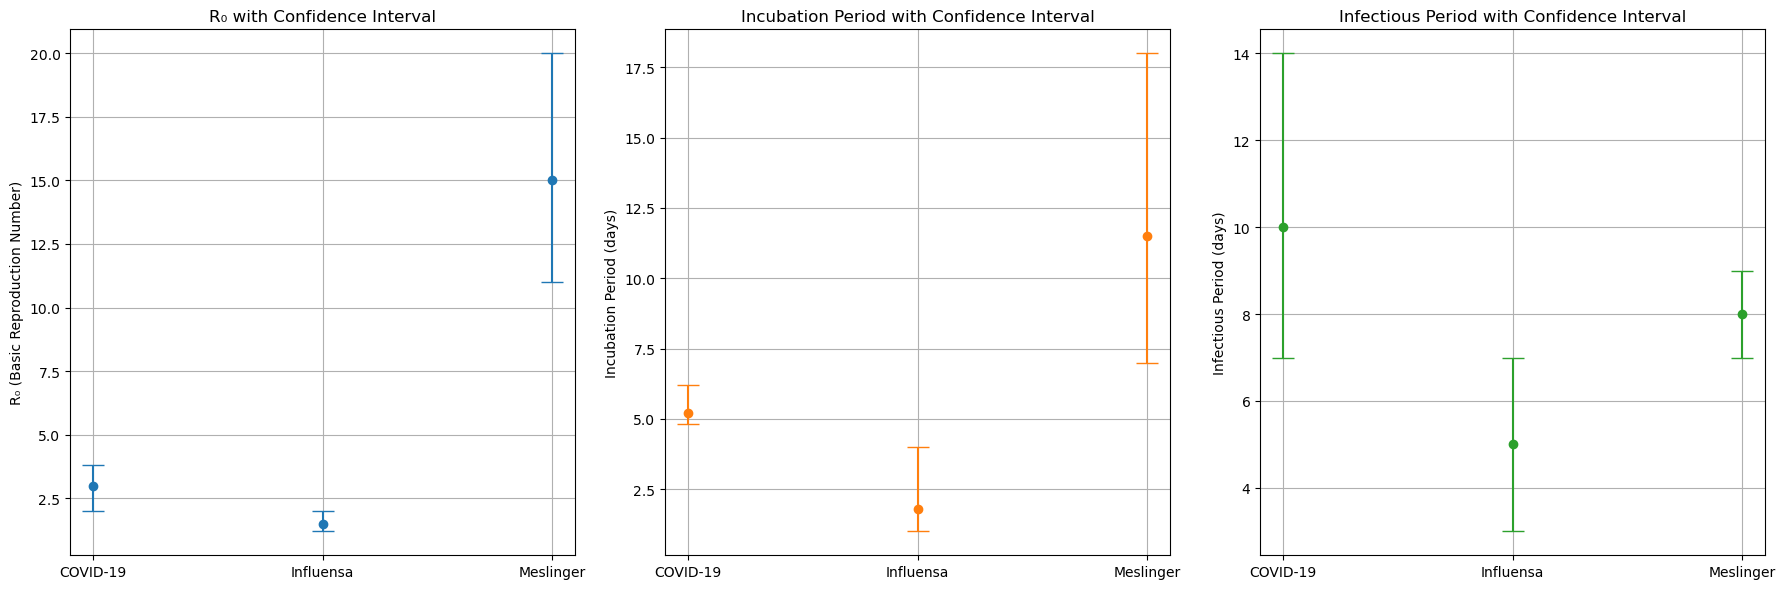

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=False)
ax = axs[0]

# R0 subplot
diseases = df_table.index.tolist()
r0_means = df_table['R0 (mean)'].values
r0_cis = np.array([df_table.loc[d, 'R0 (CI)'] for d in diseases])
r0_err_lower = r0_means - r0_cis[:, 0]
r0_err_upper = r0_cis[:, 1] - r0_means
ax.errorbar(diseases, r0_means, yerr=[r0_err_lower, r0_err_upper], fmt='o', capsize=8, color='tab:blue')
ax.set_ylabel('R₀ (Basic Reproduction Number)')
ax.set_title('R₀ with Confidence Interval')
ax.grid(True)

# Incubation subplot
ax_inc = axs[1]
inc_means = df_table['incubation (mean)'].values
inc_cis = np.array([df_table.loc[d, 'incubation (CI)'] for d in diseases])
inc_err_lower = inc_means - inc_cis[:, 0]
inc_err_upper = inc_cis[:, 1] - inc_means
ax_inc.errorbar(diseases, inc_means, yerr=[inc_err_lower, inc_err_upper], fmt='o', capsize=8, color='tab:orange')
ax_inc.set_ylabel('Incubation Period (days)')
ax_inc.set_title('Incubation Period with Confidence Interval')
ax_inc.grid(True)

# Infectious period subplot
ax_inf = axs[2]
inf_means = df_table['infectious_period (mean)'].values
inf_cis = np.array([df_table.loc[d, 'infectious_period (CI)'] for d in diseases])
inf_err_lower = inf_means - inf_cis[:, 0]
inf_err_upper = inf_cis[:, 1] - inf_means
ax_inf.errorbar(diseases, inf_means, yerr=[inf_err_lower, inf_err_upper], fmt='o', capsize=8, color='tab:green')
ax_inf.set_ylabel('Infectious Period (days)')
ax_inf.set_title('Infectious Period with Confidence Interval')
ax_inf.grid(True)

plt.tight_layout()
plt.show()



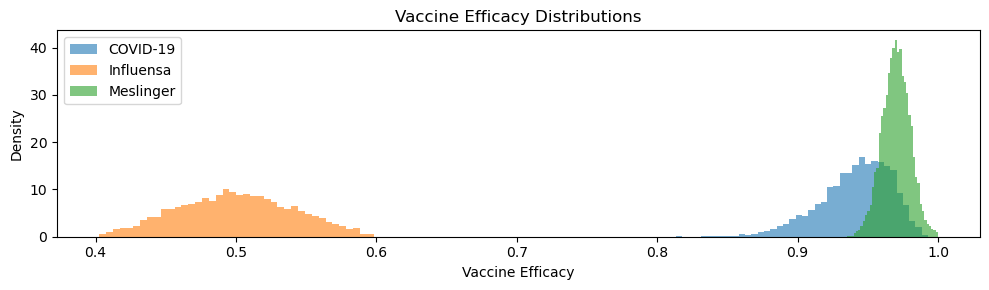

In [5]:
# Sample vaccine efficacy for each disease and plot distributions

n_samples = 5000
fig, ax = plt.subplots(figsize=(10, 3))

for disease, dist_info in vaccine_distributions.items():
    if dist_info['type'] == 'beta':
        a = dist_info['params']['a']
        b = dist_info['params']['b']
        samples = np.random.beta(a, b, n_samples)
    elif dist_info['type'] == 'triangular':
        left = dist_info['params']['left']
        mode = dist_info['params']['mode']
        right = dist_info['params']['right']
        samples = np.random.triangular(left, mode, right, n_samples)
    elif dist_info['type'] == 'truncnorm':
        mean = dist_info['params']['mean']
        std = dist_info['params']['std']
        lower = dist_info['params']['lower']
        upper = dist_info['params']['upper']
        a, b = (lower - mean) / std, (upper - mean) / std
        samples = stats.truncnorm(a, b, loc=mean, scale=std).rvs(n_samples)
    else:
        continue

    ax.hist(samples, bins=40, alpha=0.6, label=disease, density=True)

ax.set_xlabel('Vaccine Efficacy')
ax.set_ylabel('Density')
ax.set_title('Vaccine Efficacy Distributions')
ax.legend()
plt.tight_layout()
plt.show()

## En SEIR model
SEIR-modellen er en matematisk modell som brukes til å simulere spredning av smittsomme sykdommer i en befolkning. Modellen deler befolkningen inn i fire grupper: mottakelige (S), eksponerte (E), infiserte (I) og friskmeldte (R). Ved å justere parametere som smitterate, inkubasjonstid og smittevarighet, kan SEIR-modellen gi innsikt i hvordan et utbrudd utvikler seg over tid og hvordan tiltak som vaksinasjon påvirker smittespredningen.

In [6]:
# Interaktiv SEIR-modell for epidemiologisk simulering


# SEIRV modell

def seir_model(y, t, N, beta, sigma, gamma, vaccination_coverage=0, vaccine_efficacy=0):
    S, E, I, R = y
    effective_S = S - vaccination_coverage * vaccine_efficacy * S
    dSdt = -beta * effective_S * (I+0*E) / N
    dEdt = beta * effective_S * (I+0*E) / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

# Simuleringsfunksjon

def run_simulation(R0, incubation_days, infectious_days,  population, days,initial_infected, vaccination_coverage=0, vaccine_efficacy=0,reporting_delay=0, testing_delay=0):
    gamma = 1.0 / infectious_days
    sigma = 1.0 / incubation_days
    beta = R0 * gamma
    effective_population = population * (1 - vaccination_coverage * vaccine_efficacy)
    
    S0 = effective_population - initial_infected
    I0 = 0
    E0 = initial_infected
    R0_init = 0
    y0 = S0, E0, I0, R0_init

    t = np.linspace(0, days, days)

    ret = odeint(seir_model, y0, t, args=(effective_population, beta, sigma, gamma, vaccination_coverage, vaccine_efficacy))
    S, E, I, R = ret.T

    reported_I = np.roll(I, int(reporting_delay + testing_delay))
    reported_I[:int(reporting_delay + testing_delay)] = 0
    # DataFrame for time series
    df = pd.DataFrame({
        'Dager': t,
        'Ubeskyttet': S,
        'Eksponert': E,
        'Infisert': I,
        'Friskmeldt': R,
        'Rapportert infeksjon': reported_I
    })

    # DataFrame for parameters (single row)
    params_df = pd.DataFrame([{
        'R₀': R0,
        'Inkubasjon': incubation_days,
        'Smittevarighet': infectious_days,
        'Dekningsgrad': vaccination_coverage,
        'Effektivitet': vaccine_efficacy,
        'Rapportforsinkelse': reporting_delay,
        'Testforsinkelse': testing_delay,
        'Populasjon': population,
        'Startinfiserte': initial_infected
    }])

   
    return df, params_df
    


## Enkel simulering 

For å simulere og plotte SEIR-modellen med gjennomsnittlige parametere for én sykdom, bruk følgende kode. Dette gir en enkel simulering med mean R₀, inkubasjonstid og smittevarighet fra tabellen.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output


# Velg sykdom og hent gjennomsnittsparametere
# Interactive widgets for disease and population size
disease_widget = widgets.Dropdown(
    options=list(disease_params.keys()),
    value="COVID-19",
    description="Sykdom:",
    style={'description_width': 'initial'}
)
population_widget = widgets.IntText(
    value=100_000,
    description='Populasjon:',
    style={'description_width': 'initial'}
)
days_slider = widgets.IntSlider(
    value=120,
    min=30,
    max=365,
    step=1,
    description='Antall dager:',
    style={'description_width': 'initial'}
)
run_button = widgets.Button(description="Kjør simulering")
output = widgets.Output()

def run_interactive_simulation(b):
    with output:
        clear_output(wait=True)
        disease = disease_widget.value
        population = population_widget.value
        params = disease_params[disease]
        R0 = params["R0"]["mean"]
        incubation_days = params["incubation"]["mean"]
        infectious_days = params["infectious_period"]["mean"]
        initial_infected = 10
        vaccination_coverage = 0.0
        vaccine_efficacy = 0.0
        reporting_delay = 0
        testing_delay = 0
        days = days_slider.value

        df, _ = run_simulation(
            R0,
            incubation_days,
            infectious_days,
            population,
            days,
            initial_infected,
            vaccination_coverage,
            vaccine_efficacy,
            reporting_delay,
            testing_delay
        )
        

        plt.figure(figsize=(8, 3))
        plt.plot(df['Dager'], df['Ubeskyttet'], label='Ubeskyttet (S)')
        plt.plot(df['Dager'], df['Eksponert'], label='Eksponert (E)')
        plt.plot(df['Dager'], df['Infisert'], label='Infisert (I)')
        plt.plot(df['Dager'], df['Friskmeldt'], label='Friskmeldt (R)')
        plt.xlabel('Dager')
        plt.ylabel('Antall personer')
        plt.title(f'SEIR-simulering med gjennomsnittlige parametere: {disease}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

run_button.on_click(run_interactive_simulation)
display(disease_widget, population_widget, days_slider, run_button, output)


Dropdown(description='Sykdom:', options=('COVID-19', 'Influensa', 'Meslinger'), style=DescriptionStyle(descrip…

IntText(value=100000, description='Populasjon:', style=DescriptionStyle(description_width='initial'))

IntSlider(value=120, description='Antall dager:', max=365, min=30, style=SliderStyle(description_width='initia…

Button(description='Kjør simulering', style=ButtonStyle())

Output()

## Effektiv reproduksjonstall (Rt)

Det effektive reproduksjonstallet, Rt, beskriver hvor mange personer én smittet person i gjennomsnitt smitter videre på et gitt tidspunkt i en epidemi. Rt tar hensyn til at ikke hele befolkningen er mottakelig for smitte, for eksempel på grunn av immunitet etter sykdom eller vaksinasjon. Rt beregnes som:

$$
R_t = R_0 \cdot \frac{S}{N}
$$

Her er $R_0$ det grunnleggende reproduksjonstallet, $S$ antall mottakelige personer, og $N$ total populasjon. Når andelen mottakelige synker, reduseres Rt, og epidemien vil etter hvert avta når Rt < 1.

Nedenfor vises hvordan Rt synker når andelen mottakelige personer ($S/N$) reduseres:


In [61]:
import ipywidgets as widgets
from IPython.display import display, clear_output


# Velg sykdom og hent gjennomsnittsparametere
# Interactive widgets for disease and population size
disease_widget = widgets.Dropdown(
    options=list(disease_params.keys()),
    value="COVID-19",
    description="Sykdom:",
    style={'description_width': 'initial'}
)
population_widget = widgets.IntText(
    value=100_000,
    description='Populasjon:',
    style={'description_width': 'initial'}
)
days_slider = widgets.IntSlider(
    value=120,
    min=30,
    max=365,
    step=1,
    description='Antall dager:',
    style={'description_width': 'initial'}
)
run_button = widgets.Button(description="Kjør simulering")
output = widgets.Output()

def run_interactive_simulation(b):
    with output:
        clear_output(wait=True)
        disease = disease_widget.value
        population = population_widget.value
        params = disease_params[disease]
        R0 = params["R0"]["mean"]
        incubation_days = params["incubation"]["mean"]
        infectious_days = params["infectious_period"]["mean"]
        initial_infected = 10
        vaccination_coverage = 0.0
        vaccine_efficacy = 0.0
        reporting_delay = 0
        testing_delay = 0
        days = days_slider.value

        df, _ = run_simulation(
            R0,
            incubation_days,
            infectious_days,
            population,
            days,
            initial_infected,
            vaccination_coverage,
            vaccine_efficacy,
            reporting_delay,
            testing_delay
        )
        

        plt.figure(figsize=(8, 3))
        #plt.plot(df['Dager'], df['Ubeskyttet'], label='Ubeskyttet (S)')
        plt.plot(df['Dager'], df['Infisert'], label='Infisert (I)')
        plt.xlabel('Dager')
        plt.ylabel('Antall personer')
        plt.title(f'SEIR-simulering med gjennomsnittlige parametere: {disease}')
        ax2 = plt.gca().twinx()
        ax2.plot(df['Dager'], R0 * df['Ubeskyttet'] / population, color='tab:red', label='Rt')
        ax2.set_ylabel('Rt (Effektiv reproduksjonstall)', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        
        
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

run_button.on_click(run_interactive_simulation)
display(disease_widget, population_widget, days_slider, run_button, output)


Dropdown(description='Sykdom:', options=('COVID-19', 'Influensa', 'Meslinger'), style=DescriptionStyle(descrip…

IntText(value=100000, description='Populasjon:', style=DescriptionStyle(description_width='initial'))

IntSlider(value=120, description='Antall dager:', max=365, min=30, style=SliderStyle(description_width='initia…

Button(description='Kjør simulering', style=ButtonStyle())

Output()

In [60]:
def draw_vaccination_samples(dist_info, n_samples=1):
    """
    Draw random samples from the specified vaccine efficacy distribution.

    Parameters:
        dist_info (dict): Distribution info, e.g. vaccine_distributions['COVID-19']
        n_samples (int): Number of samples to draw

    Returns:
        np.ndarray: Array of sampled vaccine efficacy values
    """
    if dist_info['type'] == 'beta':
        a = dist_info['params']['a']
        b = dist_info['params']['b']
        return np.random.beta(a, b, n_samples)
    elif dist_info['type'] == 'triangular':
        left = dist_info['params']['left']
        mode = dist_info['params']['mode']
        right = dist_info['params']['right']
        return np.random.triangular(left, mode, right, n_samples)
    elif dist_info['type'] == 'truncnorm':
        mean = dist_info['params']['mean']
        std = dist_info['params']['std']
        lower = dist_info['params']['lower']
        upper = dist_info['params']['upper']
        a, b = (lower - mean) / std, (upper - mean) / std
        return stats.truncnorm(a, b, loc=mean, scale=std).rvs(n_samples)
    else:
        raise ValueError("Unknown distribution type")


## Monte Carlo
Monte Carlo-metoden er en statistisk teknikk som bruker tilfeldige simuleringer for å analysere usikkerhet og variasjon i modeller. Ved å trekke tilfeldige verdier for modellparametere fra sannsynlighetsfordelinger, kan vi kjøre mange simuleringer og undersøke hvordan utfallet varierer. Dette gir innsikt i sannsynlige utfall og spredning, og brukes ofte i epidemiologi for å forstå hvordan usikkerhet i for eksempel smitterate eller vaksineeffektivitet påvirker sykdomsutbrudd.

In [52]:


def run_monte_carlo(days,n_runs, disease, population, initial_infected=10, vaccination_coverage=0.,reporting_delay=0, testing_delay=0, plot=True, ax=None):
    results = []
    t = np.linspace(0, days, days)
    params = disease_params[disease]
    incubation_days = np.random.uniform(params["incubation"]["CI"][0], params["incubation"]["CI"][1], size=n_runs)
    infectious_days = np.random.uniform(params["infectious_period"]["CI"][0], params["infectious_period"]["CI"][1], size=n_runs)
    R0 = np.random.uniform(params["R0"]["CI"][0], params["R0"]["CI"][1], size=n_runs)

    vaccine_efficacy = draw_vaccination_samples(vaccine_distributions[disease], n_runs)

    df_collect = []

    df_params_collect = pd.DataFrame({
        'R0': R0,
        'Inkubasjon': incubation_days,
        'Smittevarighet': infectious_days,
        'Vaksine Effektivitet': vaccine_efficacy,
    })

    for i in range(n_runs):
        gamma = 1.0 / infectious_days[i]
        sigma = 1.0 / incubation_days[i]
        beta = R0[i] * gamma
        df, params_df = run_simulation(
            R0[i],
            incubation_days[i],
            infectious_days[i],
            population,
            days,
            initial_infected,
            vaccination_coverage,
            vaccine_efficacy[i],
            reporting_delay,
            testing_delay
        )
        df_collect.append(df)

    if plot:
        plot_monte_carlo_infected(df_collect, disease,ax=ax)
    return df_collect, df_params_collect

def plot_monte_carlo_infected(dfs, disease,ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
    inf_mean = 0
    inf_std = 0
    for df in dfs:
        inf_mean += df['Infisert']
        inf_std += df['Infisert'] ** 2
    inf_mean /= len(dfs)
    inf_std = np.sqrt(inf_std / len(dfs) - inf_mean ** 2)

#    plt.plot(df['Dager'], df['Ubeskyttet'], color='gray', alpha=0.1)
    ax.plot(df['Dager'], inf_mean, label='Gjennomsnittlig infiserte', linewidth=4)

    ax.fill_between(df['Dager'], np.maximum(0, inf_mean - inf_std), inf_mean + inf_std, color='b', alpha=0.2, label='±1 Std. avvik')
    ax.set_xlabel('Dager')
    ax.set_ylabel('Antall infiserte')
    ax.set_title(f'Infiserte over tid for hver Monte Carlo-simulering: {disease}')
    ax.grid(True)
    ax.legend()
    #plt.show()


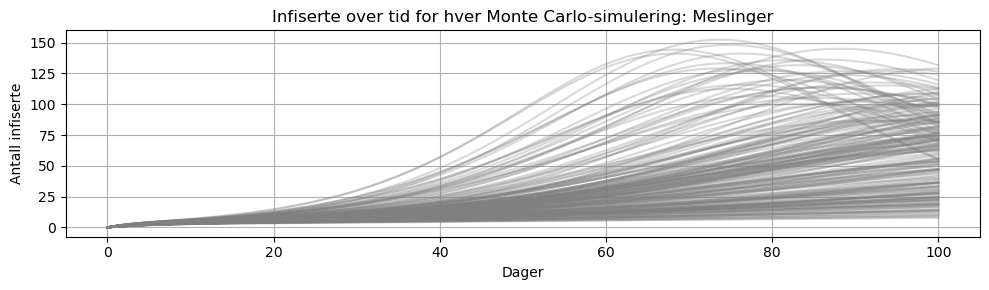

In [ ]:
disease = "Meslinger"
out=run_monte_carlo(
	days=100,
	n_runs=200,
	disease=disease,
	population=10000, vaccination_coverage=0.9,
    plot=False
)

# Unpack the output tuple from run_monte_carlo
dfs, params_dfs = out

fig, ax = plt.subplots(figsize=(10, 3))
for df in dfs:
    ax.plot(df['Dager'], df['Infisert'], alpha=0.3,color='gray')

ax.set_xlabel('Dager')
ax.set_ylabel('Antall infiserte')
ax.set_title(f'Infiserte over tid for hver Monte Carlo-simulering: {disease}')
ax.grid(True)
plt.tight_layout()
plt.show()

In [57]:
out

([         Dager   Ubeskyttet  Eksponert   Infisert  Friskmeldt  \
  0     0.000000  1246.312500  10.000000   0.000000    0.000000   
  1     1.010101  1246.238107   9.411160   0.620069    0.043164   
  2     2.020202  1246.033050   8.987426   1.129869    0.162155   
  3     3.030303  1245.720174   8.695824   1.552753    0.343749   
  4     4.040404  1245.317497   8.510221   1.907250    0.577532   
  ..         ...          ...        ...        ...         ...   
  95   95.959596  1010.203417  65.045992  29.182685  151.880407   
  96   96.969697  1004.676340  66.085504  29.703065  155.847592   
  97   97.979798   999.082537  67.120735  30.224274  159.884954   
  98   98.989899   993.423348  68.150673  30.745901  163.992578   
  99  100.000000   987.700202  69.174286  31.267521  168.170492   
  
      Rapportert infeksjon  
  0               0.000000  
  1               0.620069  
  2               1.129869  
  3               1.552753  
  4               1.907250  
  ..               

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output


# Velg sykdom og hent gjennomsnittsparametere
# Interactive widgets for disease and population size
disease_widget = widgets.Dropdown(
    options=list(disease_params.keys()),
    value="COVID-19",
    description="Sykdom:",
    style={'description_width': 'initial'}
)
population_widget = widgets.IntText(
    value=100_000,
    description='Populasjon:',
    style={'description_width': 'initial'}
)
days_slider = widgets.IntSlider(
    value=120,
    min=30,
    max=365,
    step=1,
    description='Antall dager:',
    style={'description_width': 'initial'}
)
vac_coverage_slider = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Vaksinasjonsdekning:',
    style={'description_width': 'initial'}
)

reporting_delay_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=14,
    step=1,
    description='Rapportforsinkelse (dager):',
    style={'description_width': 'initial'}
)
run_button = widgets.Button(description="Kjør simulering")
output = widgets.Output()

def run_interactive_simulation(b):
    with output:
        clear_output(wait=True)
        disease = disease_widget.value
        population = population_widget.value
        params = disease_params[disease]
        R0 = params["R0"]["mean"]
        incubation_days = params["incubation"]["mean"]
        infectious_days = params["infectious_period"]["mean"]
        initial_infected = 1
        vaccination_coverage = vac_coverage_slider.value
        vaccine_efficacy = 0.0
        reporting_delay = reporting_delay_slider.value
        testing_delay = 0
        days = days_slider.value

        dfs, _ = run_monte_carlo(
            days=days,
            n_runs=200,
            disease=disease,
            population=population,
            initial_infected=initial_infected,
            vaccination_coverage=vaccination_coverage,
            reporting_delay=reporting_delay,
            testing_delay=testing_delay,
            plot=False
        )
        inf_mean = 0
        inf_std = 0
        rep_mean = 0
        rep_std = 0
        for df in dfs:
            inf_mean += df['Infisert']
            inf_std += df['Infisert'] ** 2
            rep_mean += df['Rapportert infeksjon']
            rep_std += df['Rapportert infeksjon'] ** 2
        inf_mean /= len(dfs)
        inf_std = np.sqrt(inf_std / len(dfs) - inf_mean ** 2)
        rep_mean /= len(dfs)
        rep_std = np.sqrt(rep_std / len(dfs) - rep_mean ** 2)

        with output:
            clear_output(wait=True)
            plt.plot(df['Dager'], inf_mean, alpha=0.9, color='gray')
            plt.fill_between(df['Dager'], np.maximum(0, inf_mean - inf_std), inf_mean + inf_std, color='b', alpha=0.2)
            if reporting_delay > 0:
                plt.plot(df['Dager'], rep_mean, alpha=0.9, color='blue')
                plt.fill_between(df['Dager'], np.maximum(0, rep_mean - rep_std), rep_mean + rep_std, color='cyan', alpha=0.2)
            plt.xlabel('Dager')
            plt.ylabel('Antall infiserte')
            plt.title(f'Infiserte over tid for hver Monte Carlo-simulering: {disease}')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

run_button.on_click(run_interactive_simulation)
display(disease_widget, population_widget, days_slider, vac_coverage_slider, reporting_delay_slider,run_button, output)


Dropdown(description='Sykdom:', options=('COVID-19', 'Influensa', 'Meslinger'), style=DescriptionStyle(descrip…

IntText(value=100000, description='Populasjon:', style=DescriptionStyle(description_width='initial'))

IntSlider(value=120, description='Antall dager:', max=365, min=30, style=SliderStyle(description_width='initia…

FloatSlider(value=0.0, description='Vaksinasjonsdekning:', max=1.0, step=0.05, style=SliderStyle(description_w…

IntSlider(value=0, description='Rapportforsinkelse (dager):', max=14, style=SliderStyle(description_width='ini…

Button(description='Kjør simulering', style=ButtonStyle())

Output()

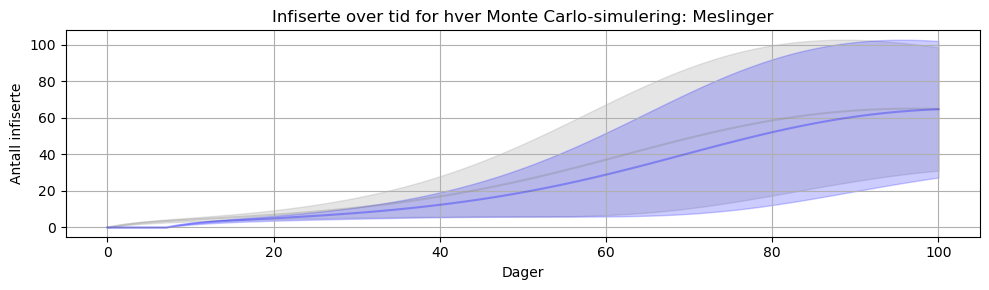

In [85]:
disease = "Meslinger"
out=run_monte_carlo(
	days=100,
	n_runs=200,
	disease=disease,
	population=10000, vaccination_coverage=0.9,
    testing_delay=5,
    reporting_delay=2,
    plot=False
)

inf_mean = 0
inf_std = 0
rep_mean=0
rep_std=0
for df in dfs:
    inf_mean += df['Infisert']
    inf_std += df['Infisert'] ** 2
    rep_mean += df['Rapportert infeksjon']
    rep_std += df['Rapportert infeksjon'] ** 2
inf_mean /= len(dfs)
inf_std = np.sqrt(inf_std / len(dfs) - inf_mean ** 2)
rep_mean /= len(dfs)
rep_std = np.sqrt(rep_std / len(dfs) - rep_mean ** 2)

# Unpack the output tuple from run_monte_carlo
dfs, params_dfs = out

fig, ax = plt.subplots(figsize=(10, 3))


ax.plot(df['Dager'], inf_mean, alpha=0.3,color='gray',label='Infisert')
ax.plot(df['Dager'], rep_mean, alpha=0.3,color='blue',label='Rapportert infeksjon')
ax.fill_between(df['Dager'], np.maximum(0, inf_mean - inf_std), inf_mean + inf_std, color='gray', alpha=0.2, label='Infisert ±1 Std. avvik')
ax.fill_between(df['Dager'], np.maximum(0, rep_mean - rep_std), rep_mean + rep_std, color='blue', alpha=0.2, label='Rapportert infeksjon ±1 Std. avvik')

ax.set_xlabel('Dager')
ax.set_ylabel('Antall infiserte')
ax.set_title(f'Infiserte over tid for hver Monte Carlo-simulering: {disease}')
ax.grid(True)
plt.tight_layout()
plt.show()

IndentationError: expected an indented block after 'try' statement on line 10 (145304228.py, line 11)